# ELL793 Assignment 2
**Problem 2: CIFAR-10 & CNNs** <br>
Abhinava Sikdar 2017MT01724 <br>
Yashank Singh 2017MT10756

In [16]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Is CUDA available True
Torch 1.7.0+cu101 CUDA 10.1
Device: cuda:0


## Handling Data

In [17]:
data_path='../data/'
cifar=datasets.CIFAR10(data_path, train= True, download=True, transform=transforms.ToTensor())
cifar_val=datasets.CIFAR10(data_path, train=False, download= True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


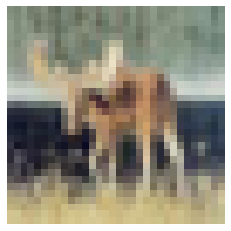

In [65]:
img, label = cifar[28]
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight',dpi=400, pad_inches = 0)
plt.show()

In [19]:
cifar_stack = torch.stack([img for img, _ in cifar], dim=3)
print('Shape of the CIFAR stack is',cifar_stack.shape)
mean= cifar_stack.view(3,-1).mean(dim=1)
std= cifar_stack.view(3,-1).std(dim=1)
print('Mean of training data is', mean)
print('Standard deviation of training data is', std)

Shape of the CIFAR stack is torch.Size([3, 32, 32, 50000])
Mean of training data is tensor([0.4914, 0.4822, 0.4465])
Standard deviation of training data is tensor([0.2470, 0.2435, 0.2616])


In [20]:
cifar_transformed = datasets.CIFAR10(data_path,train=True,download=False, transform=transforms.Compose([
                                                                                                      transforms.ToTensor(),transforms.Normalize(mean,std)
]))
cifar_val_transformed = datasets.CIFAR10(data_path,train=False,download=False, transform=transforms.Compose([
                                                                                                      transforms.ToTensor(),transforms.Normalize(mean,std)
]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


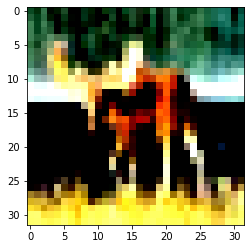

In [21]:
img, label = cifar_transformed[28]
plt.imshow(img.permute(1, 2, 0))
plt.show()

## The Convolutional Neural Net

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
batch_size=512
val_batch_size=5000
num_epochs=100
learning_rate=2*1e-3

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size,shuffle=True)
train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=5000,shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False)

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.07),

            # Block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

cnn = CNN()
cnn=cnn.to(dev)
loss_func= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate,weight_decay=3*10e-4)

In [46]:
max_validation = 0

In [47]:
for i in range(num_epochs):

  for imgs, labels in train_loader:
    if dev is not None:
      imgs,labels=imgs.to(dev),labels.to(dev)
    out= cnn(imgs)
    loss=loss_func(out,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  correct_val = 0
  total_val = 0
  correct_train_acc=0
  total_train_acc=0

  with torch.no_grad():
    for imgs, labels in val_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      outputs = cnn(imgs) 
      _, predicted = torch.max(outputs, dim=1) 
      total_val += labels.shape[0]
      correct_val += int((predicted == labels).sum())
    

    for train_acc_imgs,train_acc_labels in train_acc_loader:
      if dev is not None:
        train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
      train_acc_out=cnn(train_acc_imgs)
      _, train_acc_predicted = torch.max(train_acc_out, dim=1)
      total_train_acc += train_acc_labels.shape[0]
      correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
    if correct_val/total_val > max_validation:
      max_validation=correct_val/total_val

  if i%1==0:
    print("Epoch: %d, Loss: %f" % (i, float(loss)))
    print("Train Accuracy: ", correct_train_acc / total_train_acc)
    print("Validation Accuracy: ", correct_val / total_val)

print(max_validation)

Epoch: 0, Loss: 1.185913
Train Accuracy:  0.5789
Validation Accuracy:  0.5667
Epoch: 1, Loss: 1.027045
Train Accuracy:  0.64756
Validation Accuracy:  0.6353
Epoch: 2, Loss: 0.926604
Train Accuracy:  0.69928
Validation Accuracy:  0.6759
Epoch: 3, Loss: 0.768937
Train Accuracy:  0.74466
Validation Accuracy:  0.7234
Epoch: 4, Loss: 0.693096
Train Accuracy:  0.77096
Validation Accuracy:  0.7352
Epoch: 5, Loss: 0.667083
Train Accuracy:  0.78566
Validation Accuracy:  0.7488
Epoch: 6, Loss: 0.633060
Train Accuracy:  0.8005
Validation Accuracy:  0.7528
Epoch: 7, Loss: 0.709817
Train Accuracy:  0.81898
Validation Accuracy:  0.7698
Epoch: 8, Loss: 0.626590
Train Accuracy:  0.82558
Validation Accuracy:  0.7631
Epoch: 9, Loss: 0.608540
Train Accuracy:  0.832
Validation Accuracy:  0.7757
Epoch: 10, Loss: 0.565964
Train Accuracy:  0.83844
Validation Accuracy:  0.7767
Epoch: 11, Loss: 0.574302
Train Accuracy:  0.84482
Validation Accuracy:  0.7812
Epoch: 12, Loss: 0.688100
Train Accuracy:  0.84824
Val

In [50]:
print('The best accuracy achieved through early stopping would be', max_validation)

The best accuracy achieved through early stopping would be 0.8006
